In [1]:
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import time
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import sys
sys.path.append('/work/users/d/d/ddinh/aaco/src')
from load_dataset import load_adni_data
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
import tensorflow as tf


2024-11-11 10:55:02.290150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 10:55:02.314106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 10:55:02.321777: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 10:55:02.341576: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-11 10:55:05.152587: W tensorflow/comp

## Data

In [2]:
def load_data(file_path):
    ds = load_adni_data(file_path=file_path)
    x = ds.x
    y = ds.y
    mask_nan = np.isnan(x)
    x[mask_nan] = 0
    
    mask_nan_y = np.isnan(y)
    y[mask_nan_y] = 0
    return x, y

train_x, train_y = load_data("/work/users/d/d/ddinh/aaco/input_data/train_data.npz")
val_x, val_y = load_data("/work/users/d/d/ddinh/aaco/input_data/val_data.npz")
test_x, test_y = load_data("/work/users/d/d/ddinh/aaco/input_data/test_data.npz")

num_ts = train_x.shape[1]

In [ ]:
def get_ts(x, y): 
    x_data = np.copy(x)
    y_data = np.copy(y)
    x_ts = []
    y_ts = []
    
    for i in range(num_ts):
        x_zero = np.zeros(x_data.shape)
        x_zero[:, :i+1] = x_data[:, :i+1]
        
        non_zero_mask = np.sum(y_data[:,i,:], axis=1) != 0
        x_filtered = np.transpose(x_zero[non_zero_mask,:,:], (0, 2, 1)).reshape(-1, x_data.shape[1] * x_data.shape[2])
        x_filtered = np.concatenate([x_filtered, np.repeat(i, x_filtered.shape[0])[:, None]], axis=1)
        x_ts.append(x_filtered)
        y_ts.append(y_data[non_zero_mask, i, :])
        
    x_ts = np.concatenate(x_ts, axis=0)
    y_ts = np.concatenate(y_ts, axis=0)
    
    
    return x_ts, y_ts

test_x_ts, test_y_ts = get_ts(test_x, test_y)


In [4]:
train_x_ts, train_y_ts = get_ts(train_x, train_y)
val_x_ts, val_y_ts = get_ts(val_x, val_y)

train_x_ts = np.concatenate([train_x_ts, val_x_ts], axis=0)
train_y_ts = np.concatenate([train_y_ts, val_y_ts], axis=0)

In [5]:
# load pt file 
import torch 
path = '/work/users/d/d/ddinh/aaco/results/dataset_adni_xgb_ts.pt'
data = torch.load(path)
x = data['X']
y = data['y']
mask = data['mask']
action = data['Action']

In [6]:
merge_action = []
count = 0
for i in range(action.shape[0]):
    if action[i, 0] == 1:
        merge_action.append(action[i])
        count += 1
    else:
        merge_action[count - 1] += action[i]
merge_action = np.array(merge_action)
merge_action = merge_action[:,:-1]

In [7]:
classifiers =[]
for i in range(12):
    est = XGBClassifier(n_estimators=150, device='gpu')
    est.load_model(f"/work/users/d/d/ddinh/aaco/models/xgb_{i}.json")
    classifiers.append(est)

In [8]:
def train_classifier_with_mask(mask):
    train_X, train_Y = np.copy(train_x_ts), np.copy(train_y_ts)
    train_X = train_X.repeat(8, 0)
    train_Y = train_Y.repeat(8, 0)
    mask = mask.reshape(1, -1).repeat(train_X.shape[0], 0)
    train_X = train_X[:,:-1] * mask
    est = XGBClassifier(n_estimators=40, gpu_id=0)
    est.fit(train_X, train_Y)
    return est

In [55]:

num_ts = y.shape[1]
y_pred = np.zeros(test_y.shape)
input_eval = []

for ts in range(num_ts):
    x_input = np.zeros(test_x.shape)
    mask_input = np.zeros(merge_action.shape)
    
    x_input[:,:ts+1,:] = np.copy(test_x[:,:ts+1,:])
    for k in range(4):
        mask_input[:,k*num_ts:(k+1)*num_ts + ts] = np.copy(merge_action[:,k*num_ts:(k+1)*num_ts + ts])
    #  np.transpose(x_zero[non_zero_mask,:,:], (0, 2, 1)).reshape(-1, x_data.shape[1] * x_data.shape[2])    
    
    x_input = np.transpose(x_input, (0, 2, 1)).reshape(-1, test_x.shape[1] * test_x.shape[2])
    x_input = torch.Tensor(x_input)
    mask_input = torch.Tensor(mask_input)
    x_input = np.concatenate([x_input * mask_input, np.repeat(ts, x_input.shape[0])[:, None]], axis=1)
    
    mask_y = np.sum(test_y[:,ts], axis=1) != 0
    input_eval.append(x_input[mask_y])
    # per_mask_est = train_classifier_with_mask(mask_input.numpy())
    # pred = per_mask_est.predict_proba(x_input)
    # pred = np.array(pred)[:,0,:]
    pred = classifiers[ts].predict_proba(x_input[:,:-1])
    # pred = model.predict(x_input)
    y_pred[:,ts,:] = pred
    
input_eval = np.concatenate(input_eval, axis=0)

In [56]:
input_eval.shape, test_y_ts.shape

((1484, 49), (1484, 3))

In [57]:
def evaluate_metrics(y_pred, y_true):
    auroc_metric = tf.keras.metrics.AUC(curve='ROC', multi_label=True, num_labels=3)
    auprc_metric = tf.keras.metrics.AUC(curve='PR', multi_label=True, num_labels=3)
    # auroc_metric = tf.keras.metrics.AUC(curve='ROC', multi_label=True, num_labels=3)
    # auprc_metric = tf.keras.metrics.AUC(curve='PR', multi_label=True, num_labels=3)
    all_preds = []
    all_labels = []

    total_roc = 0
    total_pr = 0
    count = 0
    for i in range(y_pred.shape[0]):
        for t in range(y_pred.shape[1]):  
            if not np.all(y_true[i, t] == 0):  
                all_preds.append(y_pred[i, t])
                all_labels.append(y_true[i, t])
            
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    # print(all_labels.shape)
    auroc_metric.update_state(all_labels, all_preds)
    auprc_metric.update_state(all_labels, all_preds)
    
    roc_auc = auroc_metric.result().numpy()
    pr_auc = auprc_metric.result().numpy()
    
    return roc_auc, pr_auc

roc, pr = evaluate_metrics(y_pred, test_y)
print('ROC AUC:', roc)
print('PR AUC:', pr)

ROC AUC: 0.7116809
PR AUC: 0.5130516


My version

In [22]:
test_y[6]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [32]:
np.transpose(train_x, (0,2,1)).reshape(train_x.shape[0], -1)[:2]

array([[ 0.946343  ,  0.75595796,  0.39508277,  0.24957375,  0.7209328 ,
         0.13966939, -0.3207443 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.58122814, -0.58122814, -0.58122814,
        -0.58122814, -0.58122814, -0.58122814, -0.58122814,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.32096717,
         0.48678538,  0.06086014,  0.41200462,  0.42013296, -0.06269069,
         0.02428259,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55139863,  1.353316  ,  0.9956877 ,  0.4879288 ,
         0.19132923, -0.0686531 ,  0.6319566 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.44764617, -0.44764617, -0.44764617, -0.44764617, -0.17896959,
         0.        , -0.17896959,  0.        , -0.17896959,  0.        ,
         0.        ,  0.        , -1.185776  , -1.185776  , -1.185776  ,
        -1.185776  , -1.2082325 ,  0.        , -1.2082325 ,  0.        ,
   

In [33]:
train_x[:2]

array([[[ 0.946343  , -0.58122814,  0.32096717,  0.55139863],
        [ 0.75595796, -0.58122814,  0.48678538,  1.353316  ],
        [ 0.39508277, -0.58122814,  0.06086014,  0.9956877 ],
        [ 0.24957375, -0.58122814,  0.41200462,  0.4879288 ],
        [ 0.7209328 , -0.58122814,  0.42013296,  0.19132923],
        [ 0.13966939, -0.58122814, -0.06269069, -0.0686531 ],
        [-0.3207443 , -0.58122814,  0.02428259,  0.6319566 ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[-0.44764617, -1.185776  , -0.07325754,  0.        ],
        [-0.44764617, -1.185776  ,  0.0055874 ,  0.        ],
        [-0.44764617, -1.185776  ,  0.02997243,  0.        ],
        [-0.44764617, -1.185776  ,  0.02997243,  0.        ],
      

In [2]:
dataset = load_adni_data()
x = dataset.x
y = dataset.y

mask_nan = np.isnan(x)
y_nan = np.isnan(y)

x[mask_nan] = 0
y[y_nan] = 0

In [3]:
# import numpy as np

# # Assuming original shape of X is (n, 12, 4)
# def create_lagged_features(X, lag=2):
#     n, timesteps, modalities = X.shape
#     X_lagged = []

#     for t in range(lag, timesteps):
#         # Stack current timestep with lagged timesteps for each sample
#         features = X[:, t-lag:t+1, :].reshape(n, -1)  # Shape will be (n, (lag+1) * modalities)
#         X_lagged.append(features)
    
#     return np.concatenate(X_lagged, axis=0)  # Shape will be ((n * (timesteps - lag)), (lag+1) * modalities)

# # Generate lagged features
# lag = 2
# x_lagged = create_lagged_features(x, lag=lag)

# # Reshape targets accordingly to match the samples we have
# y_lagged = y[:, lag:].reshape(-1, 3)  # Remove initial timesteps for which we lack lag data
# y_lagged = np.argmax(y_lagged, axis=-1)  # Convert to class labels


In [4]:
x_all = []
for item in x:
    x_all.append(item.flatten('F'))
x_all = np.array(x_all)

In [5]:
# split dataset into train and test sets 80/20 with random seed 42
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_all, y, test_size=0.2, random_state=42)

In [6]:
# load pt file 
import torch 
path = '/work/users/d/d/ddinh/aaco/results/dataset_adni_rollout_different_masking_applyin_mask_generator_more_features.pt'
data = torch.load(path)
x = data['X']
y = data['y']
mask = data['mask']
action = data['Action']

In [7]:
merge_action = []
count = 0
for i in range(action.shape[0]):
    if action[i, 0] == 1:
        merge_action.append(action[i])
        count += 1
    else:
        merge_action[count - 1] += action[i]
merge_action = np.array(merge_action)
merge_action = merge_action[:,:-1]

In [8]:
merge_action.shape

(201, 48)

In [9]:
model = XGBClassifier()
model.load_model('/work/users/d/d/ddinh/aaco/models/adni_different_masking.model')

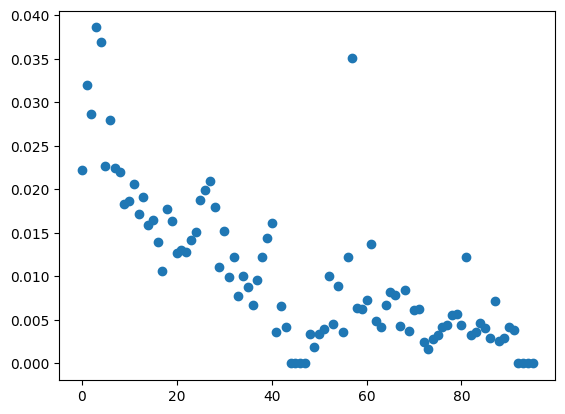

In [10]:
plt.scatter(range(len(model.feature_importances_)), model.feature_importances_)

In [11]:
x_val.shape

(201, 48)

In [12]:
num_ts = y.shape[1]
y_pred = np.zeros(y_val.shape)
for ts in range(num_ts):
    x_input = np.zeros(x_val.shape)
    mask_input = np.zeros(merge_action.shape)
    
    for k in range(4):
        x_input[:,k*ts:(k+1)*ts] = np.copy(x_val[:,k*ts:(k+1)*ts])
        mask_input[:,k*ts:(k+1)*ts] = np.copy(merge_action[:,k*ts:(k+1)*ts])
    
    x_input = torch.Tensor(x_input)
    mask_input = torch.Tensor(mask_input)
    pred = model.predict_proba(torch.cat([x_input * mask_input, mask_input], -1))
    y_pred[:,ts,:] = pred

In [13]:
y_pred.shape

(201, 12, 3)

In [14]:
np.all(np.array([1,0,0]) == 0)

False

In [16]:
def evaluate_metrics(y_pred, y_true):
    auroc_metric = tf.keras.metrics.AUC(curve='ROC')
    auprc_metric = tf.keras.metrics.AUC(curve='PR')
    
    all_preds = []
    all_labels = []

    for i in range(y_pred.shape[0]):
        for t in range(y_pred.shape[1]):  
            if not np.all(y_true[i, t] == 0):  
                all_preds.append(y_pred[i, t])
                all_labels.append(y_true[i, t])
            
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    auroc_metric.update_state(all_labels, all_preds)
    auprc_metric.update_state(all_labels, all_preds)
    roc_auc = auroc_metric.result().numpy()
    pr_auc = auprc_metric.result().numpy()
    
    return roc_auc, pr_auc

roc, pr = evaluate_metrics(y_pred, y_val)
print('ROC AUC:', roc)
print('PR AUC:', pr)

ROC AUC: 0.7112524
PR AUC: 0.478665


In [12]:
PET = 1
MRI = 0.5

merge_action_reshaped = np.copy(merge_action).reshape(-1, num_ts, 4)

In [13]:
merge_action_reshaped.shape

(200, 12, 4)

In [14]:
merge_action_reshaped[:, :, 0].shape

(200, 12)

In [29]:
total = 0
count = 0
for j in range(merge_action.shape[0]):
    total_temp = 0
    
    for i in range(4):
        if i <= 1:
            total_temp += np.sum(merge_action[j, i*num_ts:(i+1)*num_ts]) * PET
        else:
            total_temp += np.sum(merge_action[j, i*num_ts:(i+1)*num_ts]) * MRI
            
    total += total_temp 
total / merge_action_reshaped.shape[0] 

5.4275

In [17]:
5.95771144278607


5.95771144278607

In [ ]:
0.666